In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to read and clean the CSV files
def read_and_clean_csv(filename):
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Clean column names by stripping quotes and whitespace
    df.columns = df.columns.str.strip('"').str.strip()
    
    # For the first column, remove quotation marks and whitespace
    df.iloc[:, 0] = df.iloc[:, 0].str.strip('"').str.strip() if df.iloc[:, 0].dtype == 'object' else df.iloc[:, 0]
    
    return df

# Function to extract main categories
def extract_main_categories(df):
    # Identify main categories by finding rows that come right after blank rows
    # First, identify blank rows (rows where the first column is empty or NaN)
    blank_rows = df.iloc[:, 0].isna() | (df.iloc[:, 0] == '')
    
    # Find rows that come right after blank rows
    main_category_indices = []
    for i in range(1, len(blank_rows)):
        if blank_rows[i-1] and not blank_rows[i]:
            main_category_indices.append(i)
    
    # Also include the first row (which contains "Average Annual Expenditure")
    if not blank_rows[0]:
        main_category_indices.insert(0, 0)
    
    # Extract main categories and their data
    main_categories_df = df.iloc[main_category_indices].copy()
    
    return main_categories_df

# Read and clean the CSV files
df1 = read_and_clean_csv('../data/original/consumer06csv.csv')
df2 = read_and_clean_csv('../data/original/consumer13csv.csv')

# Extract main categories from each file
main_categories_df1 = extract_main_categories(df1)
main_categories_df2 = extract_main_categories(df2)

# Convert dollar values to numeric, removing $ and commas
def clean_dollar_values(df):
    for col in df.columns[1:]:  # Skip the first column (Item)
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('$', '', regex=False)
            df[col] = df[col].str.replace(',', '', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

main_categories_df1 = clean_dollar_values(main_categories_df1)
main_categories_df2 = clean_dollar_values(main_categories_df2)

# Combine the two dataframes
# First, prepare the dataframes by setting the 'Item' column as index
main_categories_df1.set_index('Item', inplace=True)
main_categories_df2.set_index('Item', inplace=True)

# Now combine them
combined_df = pd.concat([main_categories_df1, main_categories_df2], axis=1)

# Reset index to make 'Item' a column again
combined_df.reset_index(inplace=True)

# Display the combined dataframe
print("Combined data for main spending categories (2006-2020):")
print(combined_df)

# Save the combined data to a new CSV file
combined_df.to_csv('combined_consumer_spending_2006_2020.csv', index=False)
print("\nData saved to 'combined_consumer_spending_2006_2020.csv'")

Combined data for main spending categories (2006-2020):
                                              Item     2006     2007     2008  \
0                       Average Annual Expenditure  48400.0  49638.0  50486.0   
1                              Alcoholic beverages    497.0    457.0    444.0   
2                                          Housing  16366.0  16920.0  17109.0   
3                             Apparel and services   1874.0   1881.0   1801.0   
4                                   Transportation   8508.0   8758.0   8604.0   
5                                      Health care   2766.0   2853.0   2976.0   
6                                    Entertainment   2377.0   2698.0   2835.0   
7              Personal care products and services    585.0    588.0    616.0   
8                                          Reading    117.0    118.0    116.0   
9                                        Education    888.0    945.0   1046.0   
10           Tobacco products and smoking supplies   

In [9]:
combined_df.dtypes

Item     object
2006    float64
2007    float64
2008    float64
2009    float64
2010    float64
2011    float64
2012    float64
2013    float64
2014    float64
2015    float64
2016    float64
2017    float64
2018    float64
2019    float64
2020    float64
dtype: object

In [11]:
combined_df.describe(include='all')

,Item,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,29,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
unique,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Average Annual Expenditure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,11372.388889,12044.777778,12088.111111,11781.166667,11699.611111,12138.722222,12354.666667,12693.315789,13061.894737,13586.736842,14351.157895,14806.052632,15389.368421,15933.947368,15523.947368
std,NaN,21005.255021,21644.197289,21987.300810,21671.922150,21488.303191,21816.884694,22589.218261,20352.596583,21264.630114,22131.195215,23367.363813,23375.902831,24613.734019,25909.071358,26586.878952
min,NaN,-7053.000000,-2520.000000,-4072.000000,-5416.000000,-4458.000000,-1826.000000,-5092.000000,102.000000,103.000000,114.000000,118.000000,110.000000,108.000000,92.000000,114.000000
25%,NaN,650.250000,643.000000,672.000000,651.000000,648.750000,669.250000,678.250000,891.500000,1009.000000,1093.000000,1144.000000,1250.500000,1200.000000,1171.000000,1089.000000
50%,NaN,2125.500000,2057.000000,1795.000000,1914.500000,1734.500000,1876.000000,2069.500000,3631.000000,4290.000000,4342.000000,4612.000000,4928.000000,4968.000000,5193.000000,3584.000000
75%,NaN,7698.500000,7902.500000,7854.250000,7111.250000,7101.000000,7575.750000,8146.250000,10204.000000,8793.000000,9340.500000,9769.000000,12008.000000,12036.500000,11167.500000,9614.000000


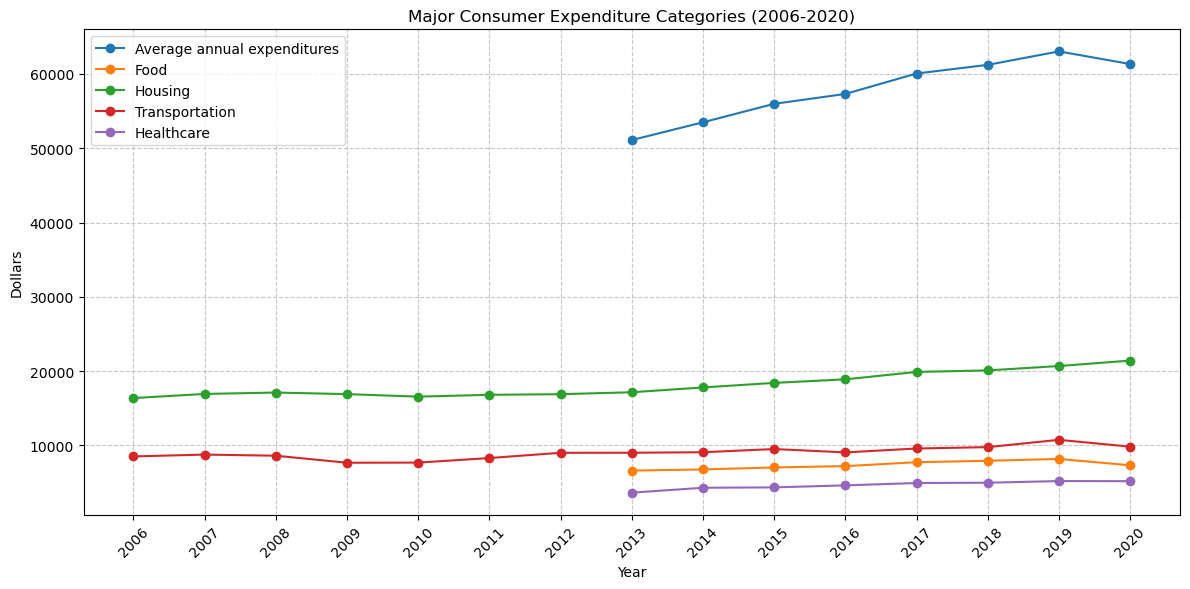

Created visualization 'consumer_spending_trends.png'

Percentage change in spending from 2006 to 2020:
Average annual expenditures: nan%
Food: nan%
Housing: 30.81%
Transportation: 15.49%
Healthcare: nan%


In [17]:
# Let's also create a visualization for one of the main categories over time
plt.figure(figsize=(12, 6))

# Select a few interesting categories to plot
categories_to_plot = ['Average annual expenditures', 'Food', 'Housing', 'Transportation', 'Healthcare']

for category in categories_to_plot:
    # Find the row for this category
    if category in combined_df['Item'].values:
        row = combined_df[combined_df['Item'] == category]
        # Extract year columns and values
        years = [col for col in row.columns if col != 'Item']
        values = row.iloc[0, 1:].values
        plt.plot(years, values, marker='o', label=category)

plt.title('Major Consumer Expenditure Categories (2006-2020)')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('consumer_spending_trends.png')
plt.show()

print("Created visualization 'consumer_spending_trends.png'")

# Let's analyze the percentage change in major categories from 2006 to 2020
if 'Item' in combined_df.columns and '2006' in combined_df.columns and '2020' in combined_df.columns:
    print("\nPercentage change in spending from 2006 to 2020:")
    for category in categories_to_plot:
        if category in combined_df['Item'].values:
            row = combined_df[combined_df['Item'] == category]
            val_2006 = row['2006'].values[0]
            val_2020 = row['2020'].values[0]
            percent_change = ((val_2020 - val_2006) / val_2006) * 100
            print(f"{category}: {percent_change:.2f}%")